# House Prices Prediction using Linear Regression

In this notebook, we will walk you through the application of linear regression to predict house prices . Linear regression is a fundamental statistical technique used to model the relationship between a dependent variable(the price) and one or more independent variables(square footage,number of bedrooms and bathrooms). By leveraging this method, we aim to develop a predictive model that can estimate the price of a house based on its features.

# 1. Data Preparation and Feature Engineering

In [1]:
import numpy as np 
import pandas as pd
from math import sqrt
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

Load the dataset.

In [2]:
# load the datasets into dataframe
train = pd.read_csv('/kaggle/input/prodigy-task-01/train.csv')
test = pd.read_csv('/kaggle/input/prodigy-task-01/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# check the number of records and columns in both of datasets
print('Number of records in train dataset: ', len(train.index))
print('Number of columns in train dataset: ', len(train.columns))
print('Number of records in test dataset: ', len(test.index))
print('Number of columns in test dataset: ', len(test.columns))

Number of records in train dataset:  1460
Number of columns in train dataset:  81
Number of records in test dataset:  1459
Number of columns in test dataset:  80


In [4]:
# check the missing values
print ('Total missing values in train set', sum(train.isna().sum()))
print ('Total missing values in test set', sum(test.isna().sum()))

Total missing values in train set 7829
Total missing values in test set 7878


In [5]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The aobve line code shows that the average sale price of a house is close to 180,000 with most of the values falling within the 130,000 to 215,000 range. Next step is to show the relationship between the columns to examine the correlations between the features and the target.

In [6]:
numeric_cols = train.select_dtypes(include = [np.number])
corr = numeric_cols.corr()
print ('The Most Correlated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[:10], '\n')
print ('The Most Uncorrelated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[-5:])

The Most Correlated Features with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

The Most Uncorrelated Features with SalePrice:
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


(None, None)

The most correlated features to sale price were the overall quality score (79%), above-ground living area (71%), Bathrooms (56%). Next step is to plot each variable individually against SalePrice in a scatter plot to check outliers as outliers can affect the regression model by pulling the estimated regression line further away from the true population regression line.

Text(0.5, 0, 'GrLivArea (Above grade "ground" living area square feet)')

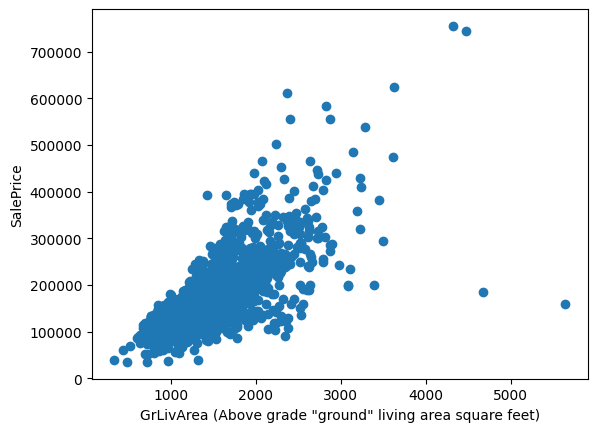

In [7]:
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea (Above grade "ground" living area square feet)')

there are increases in living area correspond to increases in price, with few outliers.

Text(0.5, 0, 'BedroomAbvGr')

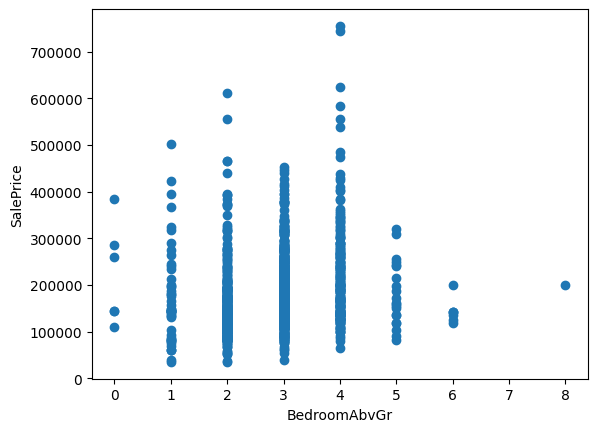

In [8]:
plt.scatter(x = train['BedroomAbvGr'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('BedroomAbvGr')

Text(0.5, 0, 'FullBath')

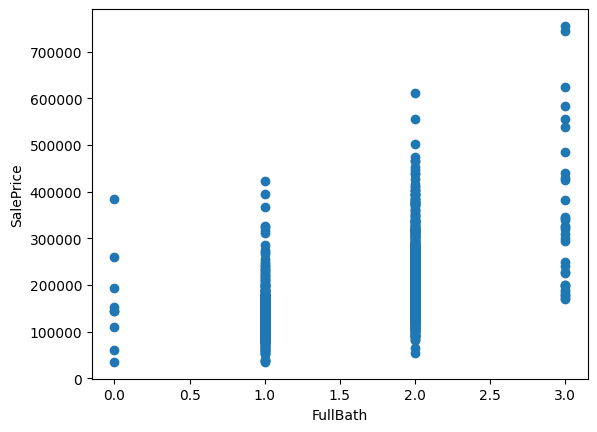

In [9]:

plt.scatter(x = train['FullBath'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('FullBath')

# Data Preprocessing

in this section the data is prepared (transformed, encoded, etc) to make it suitable for a building and training machine learning model. I chose to manually remove certain extreme outliers in the dataset to produce a better fit.

In [10]:
# remove GrLivArea outliers
train = train[train['GrLivArea'] < 4500]

In [11]:
# remove BedroomAbvGr outliers
train = train[train['BedroomAbvGr'] <= 6]

In [12]:
# drop columns with percentage of missing values > 80%
train_percentage = train.isnull().sum() / train.shape[0]
print (train_percentage[train_percentage > 0.80])
train = train.drop(train_percentage[train_percentage > 0.80].index, axis = 1)

Alley          0.938229
PoolQC         0.995882
Fence          0.807138
MiscFeature    0.962938
dtype: float64


In [13]:
# do the same with test data
test_percentage = test.isnull().sum() / test.shape[0]
print (test_percentage[test_percentage > 0.80])
test = test.drop(test_percentage[test_percentage > 0.80].index, axis = 1)

Alley          0.926662
PoolQC         0.997944
Fence          0.801234
MiscFeature    0.965045
dtype: float64


In [14]:
# encode categorical variables
le = preprocessing.LabelEncoder()
for name in train.columns:
    if train[name].dtypes == 'O':
        train[name] = train[name].astype(str)
        le.fit(train[name])
        train[name] = le.transform(train[name])

In [15]:
# do the same for testset
for name in test.columns:
    if test[name].dtypes == 'O':
        test[name] = test[name].astype(str)
        le.fit(test[name])
        test[name] = le.transform(test[name])

In [16]:
# fill missing values based on probability of occurrence
for column in train.columns:
    null_vals = train.isnull().values
    a, b = np.unique(train.values[~null_vals], return_counts = 1)
    train.loc[train[column].isna(), column] = np.random.choice(a, train[column].isnull().sum(), p = b / b.sum())

In [17]:
# apply log transformation to reduce skewness over .75 by taking log(feature + 1)
skewed_train = train.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
train[skewed_train.index] = np.log1p(train[skewed_train.index])

In [18]:
# deal with the skewness in the test data
skewed_test = test.apply(lambda x: skew(x.dropna()))
skewed_test = skewed_test[skewed_test > .75]
test[skewed_test.index] = np.log1p(test[skewed_test.index])

# Modelling

In order to train out the regression model, we need to first split up the data into an X list that contains the features to train on, and a y list with the target variable, in this case, the Price column.

In [19]:
X = train.drop(['SalePrice', 'Id'], axis = 1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [20]:
lr = linear_model.LinearRegression()

In [21]:
model = lr.fit(X_train, y_train)

In [22]:
# make predictions based on model
predictions = model.predict(X_test)

In [23]:
print ('MAE is:', mean_absolute_error(y_test, predictions))
print ('MSE is:', mean_squared_error(y_test, predictions))
print ('RMSE is:', sqrt(mean_squared_error(y_test, predictions)))

MAE is: 0.08485945735071636
MSE is: 0.01602786880287536
RMSE is: 0.12660121959473913


Text(0.5, 1.0, 'Linear Regression Model')

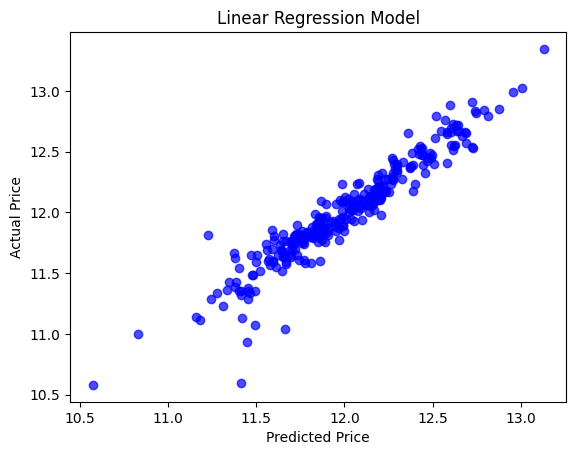

In [24]:
# alpha helps to show overlapping data
plt.scatter(predictions, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')

# Submission

In [25]:
submission = pd.DataFrame()
submission['Id'] = test['Id'].astype(int)
temp = test.select_dtypes(include = [np.number]).drop(['Id'], axis = 1).interpolate()
predictions = model.predict(temp)
predictions = np.exp(predictions)
submission['SalePrice'] = predictions
submission.to_csv('submission.csv', index = False)